In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import datasets, transforms, models


In [5]:
from google.colab import files
uploaded = files.upload()


Saving OP_Rolling_Ball_Imgs.zip to OP_Rolling_Ball_Imgs (1).zip


In [6]:
import zipfile
import os

with zipfile.ZipFile("OP_Rolling_Ball_Imgs.zip", 'r') as zip_ref:
    zip_ref.extractall("OP_Rolling_Ball_Imgs")


In [8]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from PIL import UnidentifiedImageError

class CleanImageFolder(datasets.ImageFolder):
    def __getitem__(self, index):
        try:
            return super().__getitem__(index)
        except UnidentifiedImageError:
            # Skip bad image and try the next one
            return self.__getitem__((index + 1) % len(self))

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

dataset = CleanImageFolder("OP_Rolling_Ball_Imgs", transform=transform)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

images, labels = next(iter(loader))
print(images.shape, labels)


torch.Size([32, 3, 128, 128]) tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0])


In [9]:
import os

data_path = "OP_Rolling_Ball_Imgs"
print("Class folders:", os.listdir(data_path))


Class folders: ['__MACOSX', 'OP_Rolling_Ball_Imgs']


In [10]:
# Move actual data out of nested folder
!mv OP_Rolling_Ball_Imgs/OP_Rolling_Ball_Imgs/* OP_Rolling_Ball_Imgs/

# Remove the now-empty nested folder and hidden macOS folder
!rm -r OP_Rolling_Ball_Imgs/OP_Rolling_Ball_Imgs
!rm -r OP_Rolling_Ball_Imgs/__MACOSX


In [11]:
import os

print("Class folders:", os.listdir("OP_Rolling_Ball_Imgs"))


Class folders: ['C1', 'C3']


In [12]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

dataset = datasets.ImageFolder("OP_Rolling_Ball_Imgs", transform=transform)
loader = DataLoader(dataset, batch_size=32, shuffle=True)

images, labels = next(iter(loader))
print("Shape:", images.shape)
print("Labels:", labels)
print("Classes:", dataset.classes)


Shape: torch.Size([32, 3, 128, 128])
Labels: tensor([0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1,
        0, 1, 0, 0, 1, 0, 0, 0])
Classes: ['C1', 'C3']


In [13]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, random_split

# Transform
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
])

# Load the full dataset
full_dataset = datasets.ImageFolder("OP_Rolling_Ball_Imgs", transform=transform)

# Split sizes
train_size = int(0.7 * len(full_dataset))
val_size = int(0.15 * len(full_dataset))
test_size = len(full_dataset) - train_size - val_size

train_ds, val_ds, test_ds = random_split(full_dataset, [train_size, val_size, test_size])

# Dataloaders
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
val_loader = DataLoader(val_ds, batch_size=32)
test_loader = DataLoader(test_ds, batch_size=32)

print(f"Train: {len(train_ds)} samples")
print(f"Val: {len(val_ds)} samples")
print(f"Test: {len(test_ds)} samples")


Train: 329 samples
Val: 70 samples
Test: 72 samples


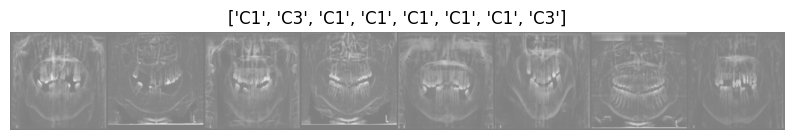

In [14]:
import matplotlib.pyplot as plt
import numpy as np
import torchvision

# Helper function to show images
def imshow(img, title=None):
    img = img / 2 + 0.5  # unnormalize if normalized
    npimg = img.numpy()
    plt.figure(figsize=(10, 4))
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    if title:
        plt.title(title)
    plt.axis('off')
    plt.show()

# Get one batch
dataiter = iter(train_loader)
images, labels = next(dataiter)

# Show images
imshow(torchvision.utils.make_grid(images[:8]), title=[full_dataset.classes[i] for i in labels[:8]])


In [15]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.fc1 = nn.Linear(32 * 32 * 32, 64)  # assuming input 128x128
        self.fc2 = nn.Linear(64, 2)  # 2 output classes (C1, C3)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))  # -> [16, 64, 64]
        x = self.pool(F.relu(self.conv2(x)))  # -> [32, 32, 32]
        x = x.view(-1, 32 * 32 * 32)          # flatten
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

model = SimpleCNN()


In [16]:
import torch.optim as optim

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


In [18]:
num_epochs = 10

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    avg_loss = running_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.4f}")


Epoch [1/10], Loss: 0.4307
Epoch [2/10], Loss: 0.3934
Epoch [3/10], Loss: 0.3161
Epoch [4/10], Loss: 0.2389
Epoch [5/10], Loss: 0.1970
Epoch [6/10], Loss: 0.1739
Epoch [7/10], Loss: 0.1640
Epoch [8/10], Loss: 0.0950
Epoch [9/10], Loss: 0.0611
Epoch [10/10], Loss: 0.0478


In [19]:
def evaluate(model, dataloader, name="Validation"):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    accuracy = 100 * correct / total
    print(f"{name} Accuracy: {accuracy:.2f}%")

# Evaluate on validation and test sets
evaluate(model, val_loader, "Validation")
evaluate(model, test_loader, "Test")


Validation Accuracy: 80.00%
Test Accuracy: 81.94%


In [20]:
from sklearn.metrics import classification_report
import torch

model.eval()
all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())


In [21]:
print(classification_report(all_labels, all_preds, target_names=full_dataset.classes))


              precision    recall  f1-score   support

          C1       0.80      0.90      0.85        41
          C3       0.85      0.71      0.77        31

    accuracy                           0.82        72
   macro avg       0.83      0.81      0.81        72
weighted avg       0.82      0.82      0.82        72

